Copyright 2020 Google Inc. All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License"); <br>
you may not use this file except in compliance with the License.<br>
You may obtain a copy of the License at<br>

     http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.<br>

See the License for the specific language governing permissions and 
limitations under the License.

In [52]:
import numpy as np
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import subprocess
import time
import pandas as pd
import os
import itertools
from collections import defaultdict 
import seaborn as sns

### Read the data

In [15]:
with open("/Users/elkir/Documents/bundle/webpacks/webpack_bodies.json") as file:
    data = file.read().split('{"page"')[1:]
    
splitted_data = set()
splitted_data.union(json.loads('{"page"' + line)["body"] for line in data)
splitted_data = splitted_data.union(json.loads('{"page"' + line)["body"] for line in data)

for i in range(50):
    name = "0" * (12 - len(str(i))) + str(i)
    with open("/Users/elkir/Documents/bundle/webpacks/webpack_bodies_" + name + ".json") as file:
        data = file.read().split('{"page"')[1:]
        splitted_data = splitted_data.union(json.loads('{"page"' + line)["body"] for line in data)

In [94]:
print("count of bundles =", len(splitted_data))

count of bundles = 13869


## Build a histogram over sizes

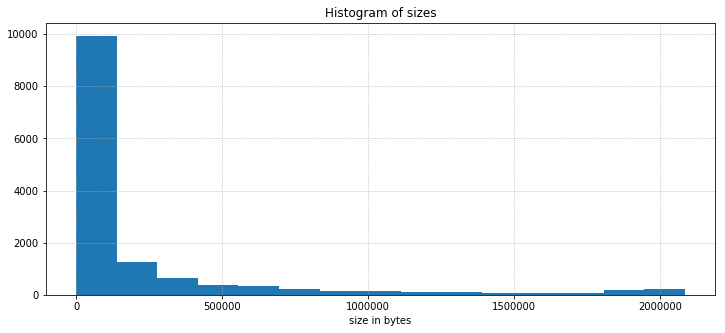

All data:
10% percentile for sizes = 1.4343750000000002 KB
90% percentile for sizes = 655.6464843750008 KB


In [91]:
sizes = [len(line) for line in splitted_data]

plt.figure(figsize=(12, 5))
plt.hist(sizes, bins=15)
plt.grid(ls=":")
plt.xlabel("size in bytes")
plt.title("Histogram of sizes")
plt.show()

print("All data:")
print("10% percentile for sizes = {} KB".format(np.percentile(sizes, 10) / 1024))
print("90% percentile for sizes = {} KB".format(np.percentile(sizes, 90) / 1024))

In [80]:
sizes = [len(line) for line in itertools.islice(splitted_data, 2000)]

print("2000 bundles:")
print("10% percentile for sizes = {} KB".format(np.percentile(sizes, 10) / 1024))
print("90% percentile for sizes = {} KB".format(np.percentile(sizes, 90) / 1024))

2000 bundles:
10% percentile for sizes = 1.45576171875 KB
90% percentile for sizes = 642.6707031250002 KB


## Calculate the amount of bits for different types of information in compressed file

Experimented only with 2000 bundles. <br>
Note that logging of such an information isn't available in main brotli github repo (I've changed the code myself). 

In [92]:
all_types = set()
type_to_bits_count_for_all = []
bits_counts = []

for j, bundle in tqdm(enumerate(itertools.islice(splitted_data, 2000))):
    with open("example.txt", "w") as file:
        file.write(bundle)
    # compress file
    result = subprocess.run(["brotli", "-q", "11", "-f", "-o", "example.txt.br", "example.txt"])  
    
    #runs brotli decompression and logs the information to log.txt
    result = subprocess.run(["bash", "brotli_decompress_and_log.sh"])
    
    
    result = subprocess.run(["wc", "-c", "example.txt.br"], stdout=subprocess.PIPE)
    count_bits = int(result.stdout.decode().strip().split()[0])
    bits_counts.append(count_bits)
    
    with open("log.txt") as file:
        logs = file.readlines()
            
    #calculate count of bits logged
    count_bits_logged = 0
    for i in range(1, len(logs) // 3):
        try:
            arr = logs[3 * i - 2].strip().split(",")[:-1]
            if len(arr) == 0:
                continue
            else:
                count_bits_logged += np.sum(list(map(int, arr)))
        except:
            print("Error encountered in reading bytes")
    
    #check that the logged bits counts is almost equal to actual bits count 
    if np.abs(count_bits - count_bits_logged) > 10:
        print("Some bits are missing in logging for {} example".format(j))
        
    # parse count of bits for different types
    type_to_bits_count = defaultdict(int)

    for i in range(1, len(logs) // 3):
        type_name = logs[3 * i - 3].strip()
        all_types.add(type_name)
        
        bits = logs[3 * i - 2].strip().split(",")[:-1]
        if len(bits) == 0:
            continue
        else:
            type_to_bits_count[type_name] += np.sum(list(map(int, bits)))
            
    type_to_bits_count_for_all.append(type_to_bits_count)

For each type calculate the ratio of bits taken for that type. <br> <br>
The ratio is $\frac{\text{count of bits for that type}}{\text{count of bits in compressed file}}$

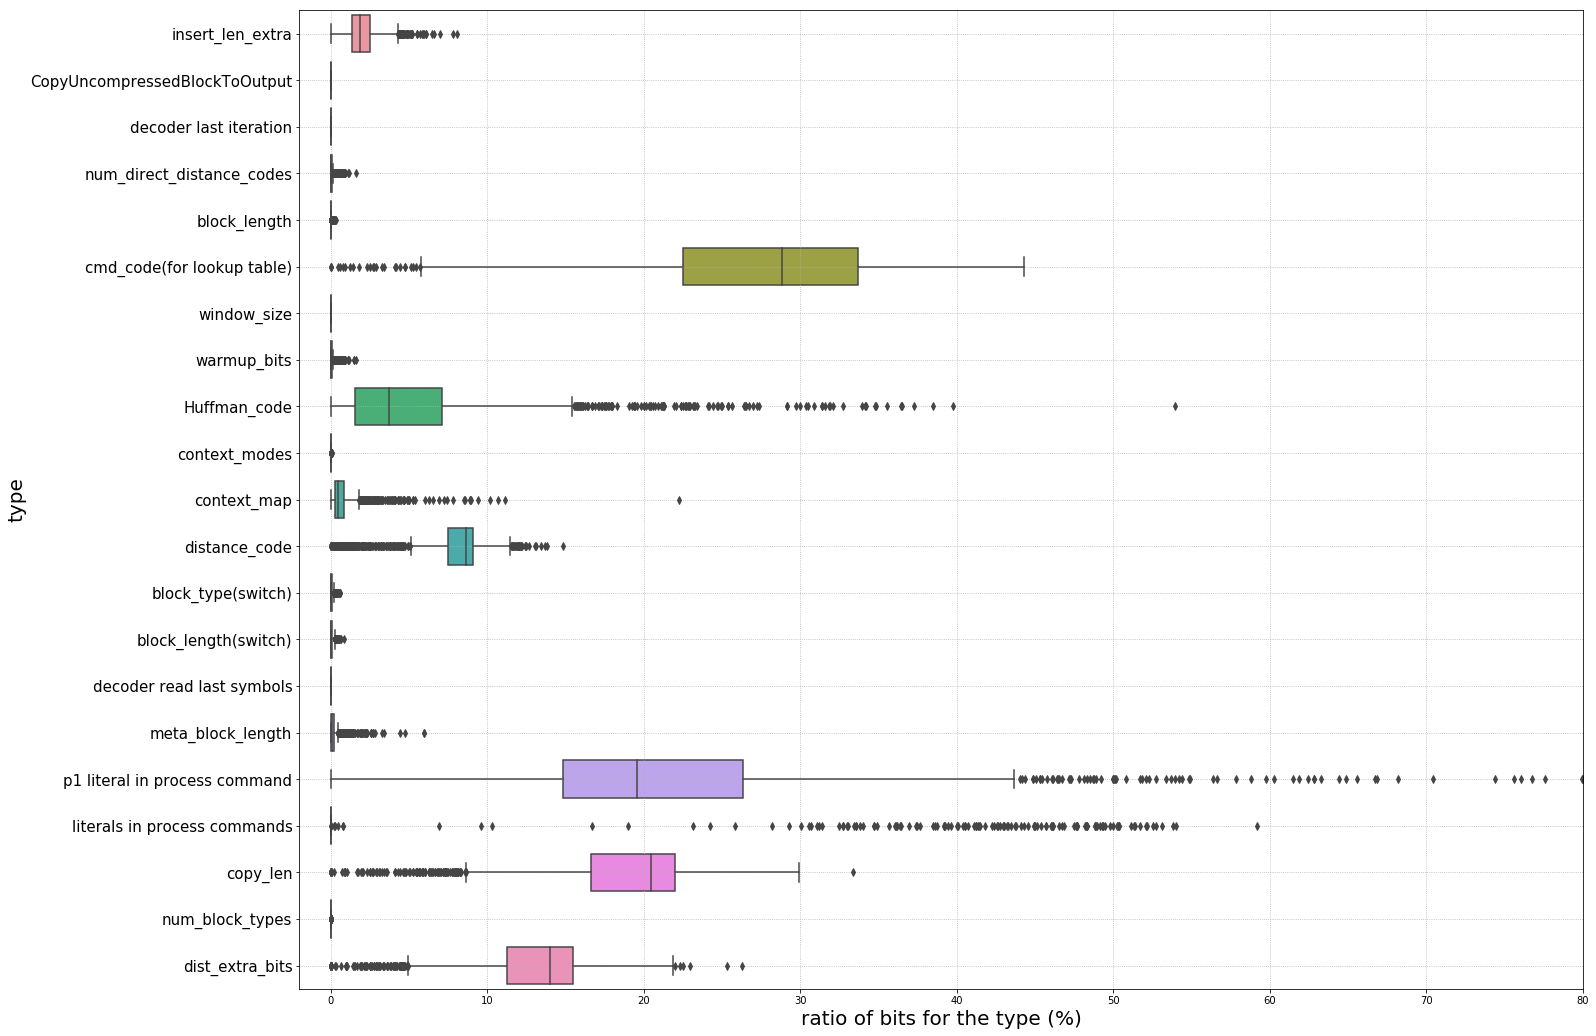

In [81]:
#accumulate the results
type_to_rates_of_bits = pd.DataFrame()

for type_name in all_types:
    rates_of_bits = []
    for i in range(len(type_to_bits_count_for_all)):
        rates_of_bits.append(type_to_bits_count_for_all[i][type_name] / bits_counts[i] * 100)
    type_to_rates_of_bits[type_name] = rates_of_bits


columns_names = np.array(list(type_to_rates_of_bits.columns))

#shorten some names
ind = np.where(columns_names == 'BrotliDecoderDecompressStream last iteration')[0][0]
columns_names[ind] = "decoder last iteration"
ind = np.where(columns_names == 'BrotliDecoderDecompressStream read last symbols')[0][0]
columns_names[ind] = "decoder read last symbols"

#plot
plt.figure(figsize=(23, 18))
ax = sns.boxplot(data=type_to_rates_of_bits, orient="h")
plt.grid(ls=":")
ax.set_xlabel("ratio of bits for the type (%)", fontsize=20)
ax.set_ylabel("type",fontsize=20)
ax.set_yticklabels(columns_names, fontsize=15)
ax.set_xlim(-2, 80)
plt.show()

**Meaning of that plot:** <br>
- Left bound of box is a 25th percentile of the data<br>
- Right bound of box is a 75th percentile of the data<br>
- Line segment inside the box is a median (50th percentile) value<br>
- Left end of horisontal segment is a minimum value(except outliers) <br>
- Right end of horisontal segment is a maximum value(except outliers) <br>
- Dots represent outliers <br><br>

*How are outliers calculated:* <br>
We at first find interquartile range which is:
$$IQR = Q_{75} - Q_{25}$$
where $Q_{75}$ - 75th percentile, $Q_{25}$ - 25th percentile.<br><br>
Then we calculate $Q_{25} - 1.5 \cdot IQR$ and $Q_{75} + 1.5 \cdot IQR$. That values will be our minimum and maximum respectively. Everything that goes after are outliers.

## Histogram of compressed sizes

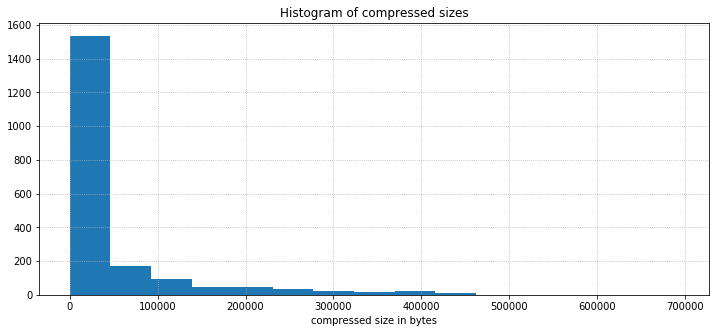

In [84]:
plt.figure(figsize=(12, 5))
plt.hist(bits_counts, bins=15)
plt.grid(ls=":")
plt.xlabel("compressed size in bytes")
plt.title("Histogram of compressed sizes")
plt.show()